In [46]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [47]:
# Load data
file_path = "Shloshim.xlsx"
df = pd.read_excel(file_path, sheet_name=0)

# Rename columns
df.rename(columns={
    'Date': 'Date',
    'NVDA UW Equity - Last Price': 'NVDA',
    'AMD UW Equity - Last Price': 'AMD'
}, inplace=True)

# Set datetime index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df = df.sort_index(ascending=True)
df[["NVDA", "AMD"]] = df[["NVDA", "AMD"]].interpolate()
df.dropna(subset=["NVDA", "AMD"], inplace=True)

df = df.sort_index()

In [48]:
# cleaning the dataset 

# # first we check for the missing values 
# # Check for missing values in each column
# missing_values = df.isnull().sum()
# missing_values

# # since there is only one missing row, then interpolate
# df.interpolate(method='linear', inplace=True)

# # confirming that missing values are handled
# missing_2 = df.isnull().sum()
# missing_2

num_cols = ["NVDA", "AMD"] # add more if needed
df[num_cols] = df[num_cols].interpolate() # linear is default
df.dropna(subset=num_cols, inplace=True) # prune any residual NaNs   

# create a rebased series
df["NVDA_rebased"] = df["NVDA"] / df["NVDA"].iloc[0]
df["AMD_rebased"]  = df["AMD"]  / df["AMD"].iloc[0]

# look at the result
display(df.head())

,NVDA,AMD,NVDA_rebased,AMD_rebased
Date,,,,
2020-03-16,4.9100,38.71,1.000000,1.000000
2020-03-17,5.4317,41.88,1.106253,1.081891
2020-03-18,5.0705,39.12,1.032688,1.010592
2020-03-19,5.3243,39.82,1.084379,1.028675
2020-03-20,5.1438,39.61,1.047617,1.023250


In [49]:
# # normalise prices to compare relative change in values 
# # min-max normalisation based on first row
# df['NVDA_norm'] = df['NVDA'] / df['NVDA'].iloc[0]
# df['AMD_norm'] = df['AMD'] / df['AMD'].iloc[0]

# # Kalman Filter for pairs trading assumes the spread is stationary 
# # calculate the spread then apply the ADF test.
# from statsmodels.tsa.stattools import adfuller

# spread = df['NVDA_norm'] - df['AMD_norm']  

# adf_result = adfuller(spread)
# print("ADF Statistic:", adf_result[0])
# print("p-value:", adf_result[1])

In [50]:
# # the p value for the last normalisation was > 0.05 so we reject null hypothesis 
# # we try log prices instead of normal ones 
# df['log_NVDA'] = np.log(df['NVDA'])
# df['log_AMD'] = np.log(df['AMD'])
# spread2 = df['log_NVDA'] - df['log_AMD']

# adf_result2 = adfuller(spread2)
# print("ADF Statistic:", adf_result2[0])
# print("p-value:", adf_result2[1])

# # p values < 0.05 so we accept null hypothesis 

In [51]:
# Run a 1‑state Kalman filter for βₜ 
df = df.sort_index(ascending=True)
def kalman_beta(y, x, q= 0.001, r= 1.0, beta0=0.0, P0=1.0):
    """Return series of time‑varying hedge ratios βₜ."""
    n = len(x)
    beta = np.empty(n)
    P = np.empty(n)

    beta[0], P[0] = beta0, P0

    for t in range(1, n):
        # Prediction
        P_pred = P[t-1] + q

        # Update
        K_t = P_pred * x[t] / (x[t]**2 * P_pred + r)
        beta[t] = beta[t-1] + K_t * (y[t] - beta[t-1] * x[t])
        P[t] = (1 - K_t * x[t]) * P_pred

    return beta

y = df["NVDA"].values
x = df["AMD"].values

beta_dyn = kalman_beta(y, x)


# STEP 3: Trim unstable Kalman estimates and align DataFrame
warmup = 30
df = df.iloc[warmup:].copy()
beta_dyn = beta_dyn[warmup:]  # match df length

# STEP 4: Assign hedge ratio and compute spread
df["beta_dyn"] = beta_dyn
df["spread_dyn"] = df["NVDA"] - df["beta_dyn"] * df["AMD"]


adf_stat, p_val, *_ = adfuller(df["spread_dyn"])
print(f"ADF stat = {adf_stat:.3f},  p‑value = {p_val:.4f}")

# the ADF stat and the p value are almost too perfect. vary q and r to make sure there isnt overfitting 

ADF stat = -7.441,  p‑value = 0.0000


Intercept α  : -51.809697
Hedge ratio β:  0.891898
ADF stat = -0.430,  p‑value = 0.9050


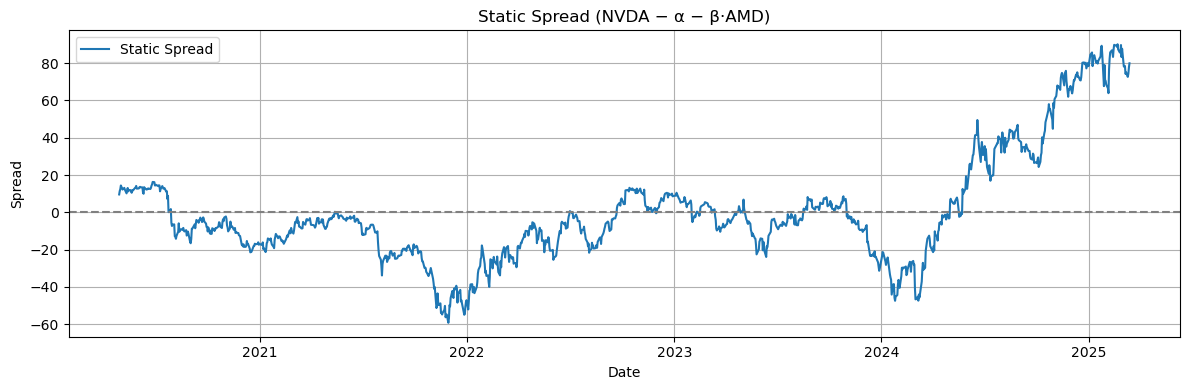

In [52]:
# computing the intitial hedge ratio
# this ratio tells us how many of AMD we need to buy to hedge NVDA 


# STEP 1: Sort and trim the dataset early
df = df.sort_index(ascending=True)
 

# STEP 2: Define price series
X = df['AMD']
Y = df['NVDA']

# STEP 3: Add constant term for intercept in OLS
X_const = sm.add_constant(X)

# STEP 4: Fit linear regression model
ols_model = sm.OLS(Y, X_const).fit()
alpha = ols_model.params['const']
beta  = ols_model.params['AMD']

print(f"Intercept α  : {alpha: .6f}")
print(f"Hedge ratio β: {beta: .6f}")

# STEP 5: Compute static spread
df["spread_static"] = Y - (alpha + beta * X)

# STEP 6: ADF test for stationarity
adf_stat, p_val, *_ = adfuller(df["spread_static"].dropna())
print(f"ADF stat = {adf_stat:.3f},  p‑value = {p_val:.4f}")

# STEP 7 (optional): Plot the spread
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(df.index, df["spread_static"], label="Static Spread")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Static Spread (NVDA − α − β·AMD)")
plt.xlabel("Date")
plt.ylabel("Spread")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

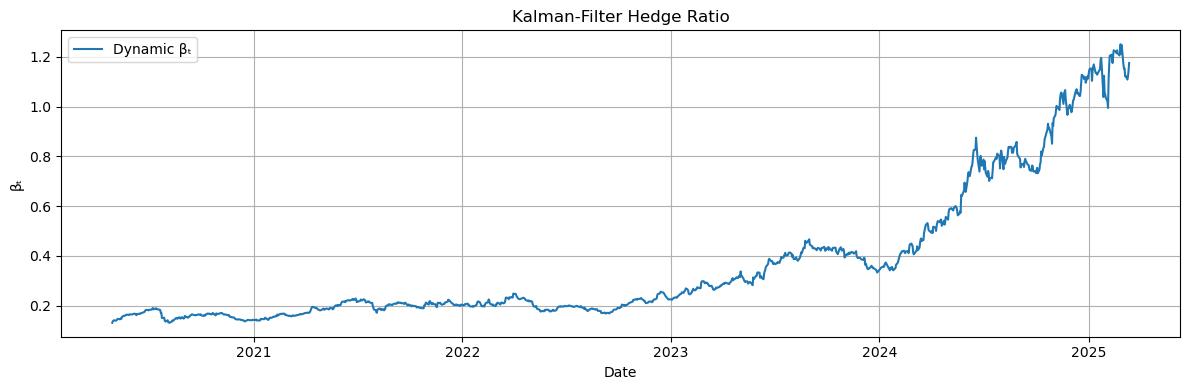

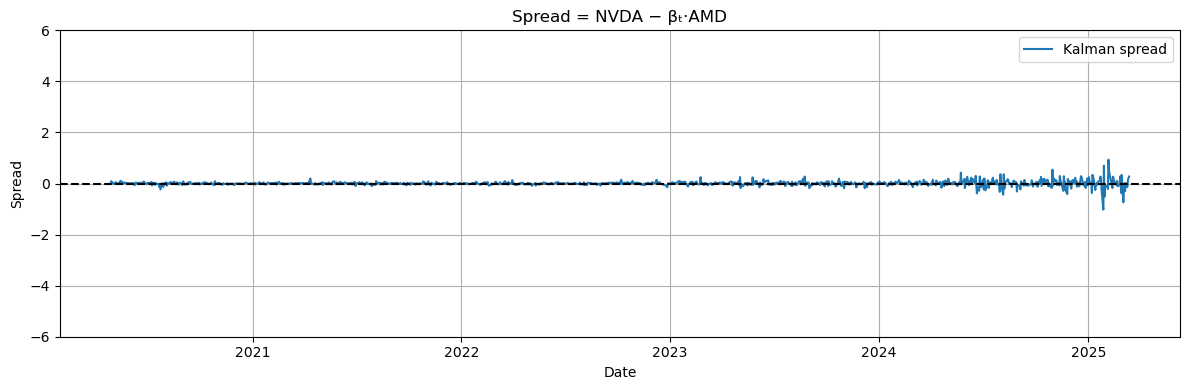

In [53]:
# 8 a. Hedge ratio
plt.figure(figsize=(12, 4))
plt.plot(df.index, beta_dyn, label="Dynamic βₜ")
plt.title("Kalman‑Filter Hedge Ratio")
plt.xlabel("Date");  plt.ylabel("βₜ")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# 8 b. Spread
plt.figure(figsize=(12, 4))
plt.plot(df.index, df["spread_dyn"], label="Kalman spread")
plt.ylim(-6,6)
plt.axhline(0, color="k", ls="--")
plt.title("Spread = NVDA − βₜ·AMD")
plt.xlabel("Date");  plt.ylabel("Spread")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


In [54]:
# 9 a. Z‑score 
mean_s = df["spread_dyn"].mean()
std_s  = df["spread_dyn"].std(ddof=0)
df["z"] = (df["spread_dyn"] - mean_s) / std_s

# 9 b. Raw entry/exit signals (time‑t decision) 
entry_z = 0.8   # enter at ±0.8σ instead of ±1σ
exit_z = 0.2   # exit at ±0.2σ instead of ±0.5σ
raw_sig = pd.Series(0, index=df.index, dtype=int)
raw_sig[df["z"] < -entry_z] =  1   # long spread
raw_sig[df["z"] >  entry_z] = -1   # short spread
raw_sig[df["z"].abs() < exit_z] =  0   # exit band

 
# raw_sig[df["z"] < -1] = 1 # long spread  => long NVDA, short AMD
# raw_sig[df["z"] > 1] = -1 # short spread => short NVDA, long AMD
# raw_sig[df["z"].abs() < 0.5] = 0 # exit band

# 9 c. Lag one bar to avoid look‑ahead bias  
sig = raw_sig.shift(1).fillna(0).astype(int)

# 9 d. Position book with proper flattening 
pos = sig.replace(0, np.nan).ffill().fillna(0).astype(int)
df["position"] = pos

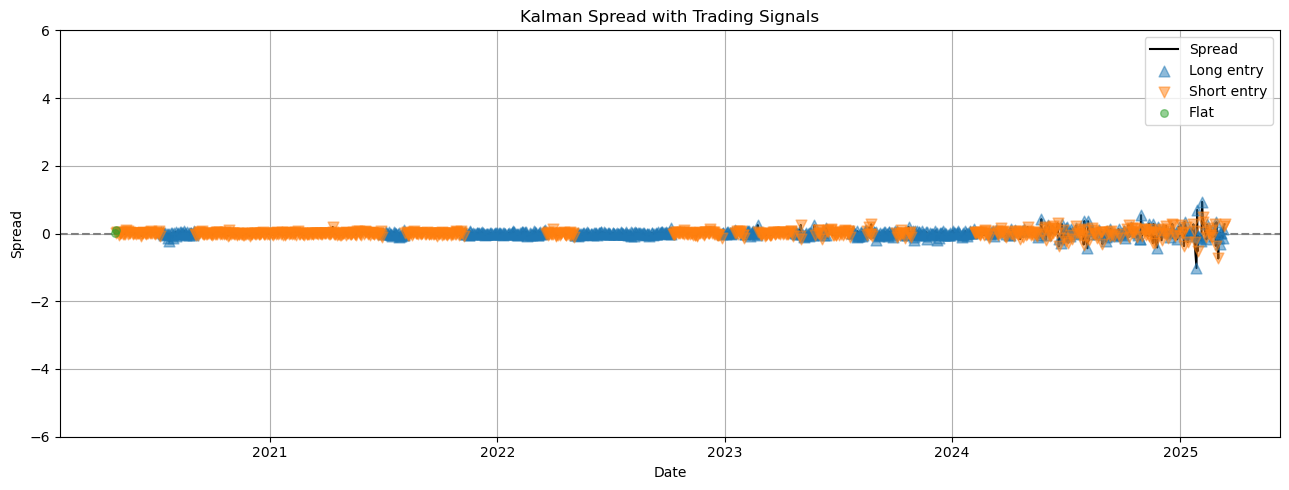

In [55]:
plt.figure(figsize=(13, 5))
plt.plot(df.index, df["spread_dyn"], color="black", label="Spread")
plt.ylim(-6,6)
plt.axhline(0, color="grey", ls="--")

plt.scatter(df.index[df["position"] ==  1],
            df["spread_dyn"][df["position"] ==  1],
            marker="^", s=60, alpha=0.5, label="Long entry", zorder=3)

plt.scatter(df.index[df["position"] == -1],
            df["spread_dyn"][df["position"] == -1],
            marker="v", s=60, alpha=0.5, label="Short entry", zorder=3)

plt.scatter(df.index[(df["position"] == 0) & (sig == 0)],
            df["spread_dyn"][(df["position"] == 0) & (sig == 0)],
            marker="o", s=30, alpha=0.5, label="Flat", zorder=3)

plt.title("Kalman Spread with Trading Signals")
plt.xlabel("Date");  plt.ylabel("Spread")
plt.grid();  plt.legend();  plt.tight_layout()
plt.show()


In [56]:
import numpy as np
import pandas as pd

# 1) PARAMETERS
capital_per_point = 10_000   # $ P&L per 1pt move in spread
trading_days     = 252

# 2) INTRADAY P&L: position(t-1) * Δspread
df["pnl"] = (
    df["position"].shift(1)    # use yesterday's position
    * df["spread_dyn"].diff()  # change in spread today
    * capital_per_point        # dollars per spread point
)
df["pnl"].fillna(0, inplace=True)

# 3) EQUITY CURVE
df["equity"] = df["pnl"].cumsum()

# 4) DAILY RETURNS (on equity)
initial_capital = 100_000
df["ret"] = df["pnl"] / initial_capital

# 5) PERFORMANCE METRICS
# Sharpe ratio (annualized)
sharpe = df["ret"].mean() / df["ret"].std(ddof=0) * np.sqrt(trading_days)

# Maximum drawdown
cum_max    = df["equity"].cummax()
drawdowns  = df["equity"] - cum_max
max_drawdown = drawdowns.min()

# 6) TRADE‑BY‑TRADE P&L FOR WIN/LOSS RATIO
# Find entry and exit indices
entries = df.index[(df["position"] != 0) & (df["position"].shift(1) == 0)]
exits   = df.index[(df["position"] == 0) & (df["position"].shift(1) != 0)]

# Align them (drop last open trade if any)
if len(exits) < len(entries):
    entries = entries[:len(exits)]
elif len(entries) < len(exits):
    exits = exits[:len(entries)]

trade_pnls = []
for entry, exit_ in zip(entries, exits):
    pnl_trade = df.at[exit_, "equity"] - df.at[entry, "equity"]
    trade_pnls.append(pnl_trade)

trade_pnls = np.array(trade_pnls)
win_trades = trade_pnls[trade_pnls > 0]
loss_trades= trade_pnls[trade_pnls < 0]

win_loss_ratio = (
    len(win_trades) / len(loss_trades)
    if len(loss_trades)>0 else np.nan
)

# 7) SUMMARY PRINT
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: ${max_drawdown:,.0f}")
print(f"Total P&L: ${df['equity'].iloc[-1]:,.0f}")
print(f"Number Trades: {len(trade_pnls)}")
print(f"Win/Loss Ratio: {win_loss_ratio:.2f}")
print(f"Avg Win / Avg Loss: "
      f"{win_trades.mean():.0f} / {loss_trades.mean():.0f}")


Sharpe Ratio: 0.20
Max Drawdown: $-25,164
Total P&L: $21,888
Number Trades: 1
Win/Loss Ratio: nan
Avg Win / Avg Loss: nan / nan


/tmp/ipykernel_121/321330962.py:64: RuntimeWarning: Mean of empty slice.
  f"{win_trades.mean():.0f} / {loss_trades.mean():.0f}")
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [57]:
import itertools

# Define the parameter grids
q_vals = [1e-5, 1e-4, 1e-3]
r_vals = [0.5, 1.0, 2.0]
entry_z_vals = [0.8, 1.0, 1.2]
exit_z_vals = [0.2, 0.5]

# Store results
results = []

# Try every combination
for q, r, entry_z, exit_z in itertools.product(q_vals, r_vals, entry_z_vals, exit_z_vals):
    beta_dyn = kalman_beta(df["NVDA"].values, df["AMD"].values, q=q, r=r)
    spread = df["NVDA"] - beta_dyn * df["AMD"]
    
    z = (spread - spread.mean()) / spread.std()
    
    sig = pd.Series(0, index=df.index)
    sig[z < -entry_z] = 1
    sig[z > entry_z] = -1
    sig[z.abs() < exit_z] = 0
    sig = sig.shift(1).fillna(0).astype(int)
    pos = sig.replace(0, np.nan).ffill().fillna(0).astype(int)
    
    pnl = pos.shift(1) * spread.diff() * 10_000
    ret = pnl / 100_000
    sharpe = ret.mean() / ret.std(ddof=0) * np.sqrt(252)
    total_pnl = pnl.cumsum().iloc[-1]

    results.append({
        "q": q, "r": r,
        "entry_z": entry_z, "exit_z": exit_z,
        "Sharpe": sharpe,
        "Total_PnL": total_pnl
    })

In [58]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="Sharpe", ascending=False).head()

,q,r,entry_z,exit_z,Sharpe,Total_PnL
0,0.00001,0.5,0.8,0.2,1.503487,1.346650e+06
1,0.00001,0.5,0.8,0.5,1.503487,1.346650e+06
12,0.00001,2.0,0.8,0.2,1.503322,1.695595e+06
13,0.00001,2.0,0.8,0.5,1.503322,1.695595e+06
15,0.00001,2.0,1.0,0.5,1.378138,1.555504e+06


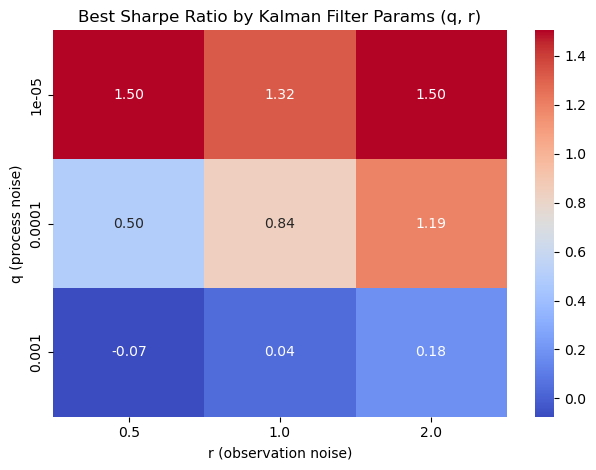

In [59]:
# Group by q and r, keep the row with the highest Sharpe ratio for each pair
best_qr = results_df.sort_values("Sharpe", ascending=False).drop_duplicates(subset=["q", "r"])

# Now pivot safely
pivot = best_qr.pivot(index="q", columns="r", values="Sharpe")

# Plot it
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(pivot, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Best Sharpe Ratio by Kalman Filter Params (q, r)")
plt.xlabel("r (observation noise)")
plt.ylabel("q (process noise)")
plt.tight_layout()
plt.show()

In [71]:
# 1. Define capital
initial_capital = 100_000
capital_per_point = 10_000
trading_days = 90

# 2. Compute P&L
df["pnl"] = (
    df["position"].shift(1) * df["spread_dyn"].diff() * capital_per_point
)
df["pnl"].fillna(0, inplace=True)

# 3. Equity and returns
df["equity"] = df["pnl"].cumsum()
df["ret"] = df["pnl"] / initial_capital

# 4. Sharpe Ratio
sharpe = df["ret"].mean() / df["ret"].std(ddof=0) * np.sqrt(trading_days)

# 5. Max Drawdown
cum_max = df["equity"].cummax()
drawdowns = df["equity"] - cum_max
max_drawdown = drawdowns.min()

# 6. Total PnL
total_pnl = df["equity"].iloc[-1]

print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: ${max_drawdown:,.0f}")
print(f"Total P&L: ${total_pnl:,.0f}")

Sharpe Ratio: 0.10
Max Drawdown: $-29,316
Total P&L: $15,525
